In [278]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LassoCV
import warnings
from sklearn.exceptions import ConvergenceWarning



# Arguments

In [279]:
args = {'noise':0.01,
        'percent training data':0.7,
        'spec scale':10**12,
        }

all_layer_args = {
        'learning rate':0.01,
        'training epochs':5000,

        'loss fn':nn.L1Loss(),
        'optimizer':torch.optim.Rprop
        }

one_layer_args = {
        'learning rate':0.01,
        'training epochs':5000,
        'feature threshold':0.2,
        'dropout':0.5,

        'loss fn':nn.L1Loss(),
        'optimizer':torch.optim.Rprop
        }

now = datetime.now()

# Data Prep

In [280]:
# fn to convert dataframes to tensors
def df_to_tensor(df):
    return torch.tensor(df.values, dtype=torch.float32)

In [281]:
df = pd.read_excel('wide_range.xlsx')

spec = df.iloc[:,11:] 
temp = df.iloc[:,:11]

In [282]:
spec

,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008
0,3.105584e-14,2.999482e-14,4.442183e-14,3.656011e-14,5.194757e-14,4.973315e-14,7.323828e-14,5.203014e-14,7.218750e-14,8.672268e-14,...,2.291410e-12,2.333930e-12,2.371461e-12,2.402093e-12,2.424702e-12,2.433566e-12,2.417632e-12,2.365972e-12,2.285583e-12,2.211520e-12
1,2.303472e-14,2.137935e-14,3.026088e-14,2.454882e-14,3.471853e-14,3.357273e-14,5.103051e-14,3.893226e-14,5.676652e-14,7.142763e-14,...,1.639899e-12,1.669825e-12,1.698490e-12,1.723560e-12,1.743375e-12,1.753393e-12,1.745497e-12,1.711668e-12,1.656824e-12,1.606307e-12
2,3.321009e-14,2.824623e-14,3.587004e-14,2.765798e-14,3.802290e-14,3.688717e-14,5.919539e-14,5.122215e-14,8.020764e-14,1.073738e-13,...,4.487510e-12,4.550427e-12,4.603621e-12,4.643395e-12,4.667637e-12,4.665521e-12,4.616247e-12,4.499595e-12,4.329608e-12,4.173042e-12
3,1.357453e-14,1.187304e-14,1.558260e-14,1.228372e-14,1.717658e-14,1.683286e-14,2.695498e-14,2.296024e-14,3.580425e-14,4.786284e-14,...,2.760638e-12,2.807683e-12,2.849087e-12,2.882405e-12,2.906159e-12,2.913462e-12,2.891133e-12,2.826217e-12,2.727201e-12,2.635977e-12
4,2.619885e-14,2.332198e-14,3.140154e-14,2.493494e-14,3.488262e-14,3.382589e-14,5.274100e-14,4.275298e-14,6.464003e-14,8.408254e-14,...,3.121194e-12,3.173340e-12,3.218273e-12,3.253581e-12,3.277914e-12,3.283670e-12,3.256076e-12,3.180625e-12,3.066965e-12,2.962253e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,3.291908e-14,2.904236e-14,3.868747e-14,3.052280e-14,4.249031e-14,4.114082e-14,6.427529e-14,5.247101e-14,7.966764e-14,1.038464e-13,...,3.492639e-12,3.541544e-12,3.586094e-12,3.622037e-12,3.646522e-12,3.650482e-12,3.617422e-12,3.531303e-12,3.402929e-12,3.284666e-12
2196,2.234104e-14,1.882600e-14,2.361172e-14,1.812234e-14,2.488261e-14,2.422053e-14,3.928364e-14,3.469407e-14,5.502010e-14,7.455935e-14,...,4.885042e-12,4.950908e-12,5.006120e-12,5.046707e-12,5.070411e-12,5.065506e-12,5.009465e-12,4.880432e-12,4.693737e-12,4.521797e-12
2197,2.847468e-14,2.408754e-14,3.030068e-14,2.326424e-14,3.189002e-14,3.105177e-14,5.022622e-14,4.412174e-14,6.973943e-14,9.391391e-14,...,2.505269e-12,2.542833e-12,2.578975e-12,2.609906e-12,2.632938e-12,2.641187e-12,2.622551e-12,2.565215e-12,2.476821e-12,2.395382e-12
2198,1.648649e-14,1.406005e-14,1.783686e-14,1.379136e-14,1.903271e-14,1.863127e-14,3.027923e-14,2.667106e-14,4.232606e-14,5.720658e-14,...,1.138944e-12,1.158522e-12,1.179434e-12,1.199129e-12,1.215649e-12,1.225428e-12,1.222663e-12,1.201639e-12,1.165695e-12,1.132607e-12


In [283]:
# scale spectrum data by 10^12
spec = spec.apply(lambda x: x*args['spec scale'])

In [284]:
spec

,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008
0,0.031056,0.029995,0.044422,0.036560,0.051948,0.049733,0.073238,0.052030,0.072187,0.086723,...,2.291410,2.333930,2.371461,2.402093,2.424702,2.433566,2.417632,2.365972,2.285583,2.211520
1,0.023035,0.021379,0.030261,0.024549,0.034719,0.033573,0.051031,0.038932,0.056767,0.071428,...,1.639899,1.669825,1.698490,1.723560,1.743375,1.753393,1.745497,1.711668,1.656824,1.606307
2,0.033210,0.028246,0.035870,0.027658,0.038023,0.036887,0.059195,0.051222,0.080208,0.107374,...,4.487510,4.550427,4.603621,4.643395,4.667637,4.665521,4.616247,4.499595,4.329608,4.173042
3,0.013575,0.011873,0.015583,0.012284,0.017177,0.016833,0.026955,0.022960,0.035804,0.047863,...,2.760638,2.807683,2.849087,2.882405,2.906159,2.913462,2.891133,2.826217,2.727201,2.635977
4,0.026199,0.023322,0.031402,0.024935,0.034883,0.033826,0.052741,0.042753,0.064640,0.084083,...,3.121194,3.173340,3.218273,3.253581,3.277914,3.283670,3.256076,3.180625,3.066965,2.962253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,0.032919,0.029042,0.038687,0.030523,0.042490,0.041141,0.064275,0.052471,0.079668,0.103846,...,3.492639,3.541544,3.586094,3.622037,3.646522,3.650482,3.617422,3.531303,3.402929,3.284666
2196,0.022341,0.018826,0.023612,0.018122,0.024883,0.024221,0.039284,0.034694,0.055020,0.074559,...,4.885042,4.950908,5.006120,5.046707,5.070411,5.065506,5.009465,4.880432,4.693737,4.521797
2197,0.028475,0.024088,0.030301,0.023264,0.031890,0.031052,0.050226,0.044122,0.069739,0.093914,...,2.505269,2.542833,2.578975,2.609906,2.632938,2.641187,2.622551,2.565215,2.476821,2.395382
2198,0.016486,0.014060,0.017837,0.013791,0.019033,0.018631,0.030279,0.026671,0.042326,0.057207,...,1.138944,1.158522,1.179434,1.199129,1.215649,1.225428,1.222663,1.201639,1.165695,1.132607


In [285]:
# add noise
noise = np.random.normal(loc=0, scale=args['noise'], size=spec.shape)
spec_noisy = spec + noise

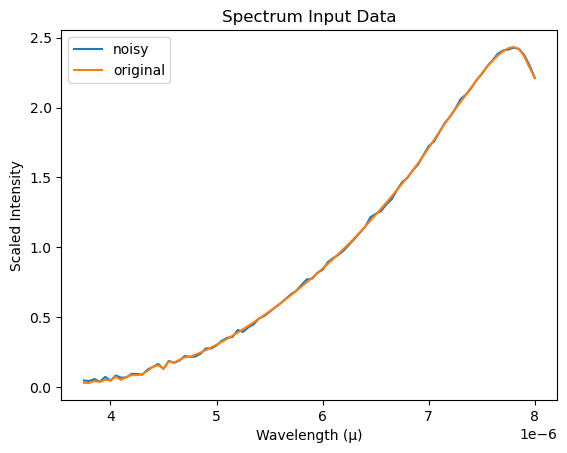

In [286]:
plt.title('Spectrum Input Data')
plt.plot(spec_noisy.iloc[0], label='noisy')
plt.plot(spec.iloc[0], label='original')
plt.xlabel("Wavelength (µ)")
plt.ylabel("Scaled Intensity")
plt.legend()
plt.show()

In [287]:
# Normalize clean and noisy spectrum data
scaler = preprocessing.StandardScaler()

scaler.fit(spec)
spec_scaled = scaler.transform(spec)

scaler.fit(spec_noisy)
spec_noisy_scaled = scaler.transform(spec_noisy)

spec_scaled_df = pd.DataFrame(spec_scaled, columns=spec.columns)
spec_noisy_scaled_df = pd.DataFrame(spec_noisy_scaled, columns = spec.columns)


/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(
/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(
/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(
/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


In [288]:
spec

,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008
0,0.031056,0.029995,0.044422,0.036560,0.051948,0.049733,0.073238,0.052030,0.072187,0.086723,...,2.291410,2.333930,2.371461,2.402093,2.424702,2.433566,2.417632,2.365972,2.285583,2.211520
1,0.023035,0.021379,0.030261,0.024549,0.034719,0.033573,0.051031,0.038932,0.056767,0.071428,...,1.639899,1.669825,1.698490,1.723560,1.743375,1.753393,1.745497,1.711668,1.656824,1.606307
2,0.033210,0.028246,0.035870,0.027658,0.038023,0.036887,0.059195,0.051222,0.080208,0.107374,...,4.487510,4.550427,4.603621,4.643395,4.667637,4.665521,4.616247,4.499595,4.329608,4.173042
3,0.013575,0.011873,0.015583,0.012284,0.017177,0.016833,0.026955,0.022960,0.035804,0.047863,...,2.760638,2.807683,2.849087,2.882405,2.906159,2.913462,2.891133,2.826217,2.727201,2.635977
4,0.026199,0.023322,0.031402,0.024935,0.034883,0.033826,0.052741,0.042753,0.064640,0.084083,...,3.121194,3.173340,3.218273,3.253581,3.277914,3.283670,3.256076,3.180625,3.066965,2.962253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,0.032919,0.029042,0.038687,0.030523,0.042490,0.041141,0.064275,0.052471,0.079668,0.103846,...,3.492639,3.541544,3.586094,3.622037,3.646522,3.650482,3.617422,3.531303,3.402929,3.284666
2196,0.022341,0.018826,0.023612,0.018122,0.024883,0.024221,0.039284,0.034694,0.055020,0.074559,...,4.885042,4.950908,5.006120,5.046707,5.070411,5.065506,5.009465,4.880432,4.693737,4.521797
2197,0.028475,0.024088,0.030301,0.023264,0.031890,0.031052,0.050226,0.044122,0.069739,0.093914,...,2.505269,2.542833,2.578975,2.609906,2.632938,2.641187,2.622551,2.565215,2.476821,2.395382
2198,0.016486,0.014060,0.017837,0.013791,0.019033,0.018631,0.030279,0.026671,0.042326,0.057207,...,1.138944,1.158522,1.179434,1.199129,1.215649,1.225428,1.222663,1.201639,1.165695,1.132607


In [289]:
spec_noisy_scaled_df    

,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008
0,1.524018,1.554918,1.556654,0.833593,2.091944,0.696291,1.329756,1.415500,0.274490,0.500992,...,-0.309792,-0.305117,-0.296445,-0.299521,-0.309536,-0.305036,-0.297808,-0.291540,-0.285254,-0.296608
1,-0.381528,-0.071767,-0.112681,0.551636,0.015601,0.664086,-0.701007,-0.270384,-0.509180,-0.901076,...,-0.788703,-0.781997,-0.791556,-0.798526,-0.786991,-0.790941,-0.789012,-0.791563,-0.797390,-0.775335
2,0.133969,0.402978,0.406120,-0.373204,0.295723,0.448868,0.139590,1.474960,0.599711,1.382651,...,1.307737,1.319929,1.312210,1.312893,1.311255,1.308945,1.316221,1.316475,1.303423,1.303471
3,-1.331972,-0.894803,-0.356247,-0.451498,-0.646189,-1.343886,-0.344014,-1.855465,-0.609794,-1.324511,...,0.034218,0.039053,0.026978,0.041977,0.050093,0.040679,0.051029,0.052706,0.054913,0.045794
4,0.575796,-0.150934,-0.082479,0.425246,0.439716,0.811807,-0.217838,-0.160194,-0.103868,0.143802,...,0.303338,0.300047,0.304494,0.311010,0.323381,0.316930,0.317262,0.308026,0.309871,0.333249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,-0.002932,1.810855,0.048826,0.329253,0.959412,0.906858,0.204041,0.124056,0.296430,1.038868,...,0.581483,0.572886,0.580256,0.578001,0.573481,0.574298,0.574671,0.590807,0.590035,0.587034
2196,-0.548372,-0.842580,-0.187570,-0.257724,-0.473294,0.282879,-0.704522,-0.475957,0.178845,-0.042500,...,1.598038,1.618039,1.585907,1.602455,1.604011,1.597995,1.594609,1.602465,1.580259,1.604808
2197,-0.192104,-1.263566,0.238080,1.053116,-0.904578,-0.039713,0.128205,-0.246271,0.664320,0.909219,...,-0.149438,-0.149791,-0.146004,-0.142816,-0.154943,-0.160034,-0.142432,-0.160858,-0.137128,-0.151780
2198,-0.005912,0.130139,-0.663868,-0.830234,-0.419107,-0.672720,-0.661348,-1.316737,-1.075269,-0.525332,...,-1.173457,-1.168164,-1.170726,-1.172873,-1.174727,-1.168016,-1.177594,-1.166744,-1.186657,-1.174305


In [290]:
temp

,layer 1,layer 2,layer 3,layer 4,layer 5,layer 6,layer 7,layer 8,layer 9,layer 10,layer 11
0,364.787366,317.684838,313.810126,303.307879,314.323118,317.828320,318.557698,308.808121,309.953331,296.299100,318.002181
1,342.552920,335.048875,325.169322,323.807685,312.667938,307.509532,318.808960,312.412740,305.472749,315.420270,301.044787
2,314.150653,325.319947,330.529579,337.855852,336.525836,349.311552,336.370506,342.758437,344.195955,333.964029,357.969610
3,302.513193,306.523372,315.214925,315.629483,313.136991,312.378427,319.314782,302.018575,306.730069,310.949569,328.143455
4,332.142887,315.836569,320.947657,325.884656,338.307720,339.673089,334.705064,325.483513,321.166972,307.175291,335.245173
...,...,...,...,...,...,...,...,...,...,...,...
2195,335.977302,330.241682,343.703154,340.218015,330.146201,328.147822,327.013308,324.117365,328.765182,349.809711,341.790695
2196,295.379242,293.251102,296.318163,309.705578,316.303984,321.883308,335.052888,332.051792,332.335927,338.805641,363.736994
2197,302.147937,330.381158,325.654767,339.596050,340.118082,331.556311,345.541835,346.354970,336.491525,344.553594,322.537128
2198,291.079250,297.187368,316.074457,317.549974,316.173049,333.928034,328.743984,333.894228,331.093773,324.365239,284.454566


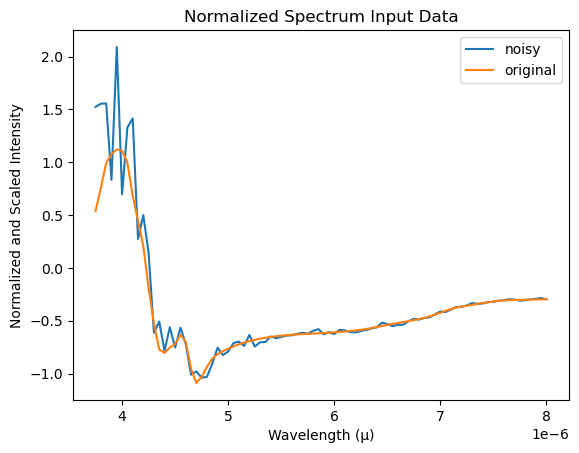

In [291]:
plt.title('Normalized Spectrum Input Data')
plt.plot(spec_noisy_scaled_df.iloc[0], label='noisy')
plt.plot(spec_scaled_df.iloc[0], label='original')
plt.xlabel("Wavelength (µ)")
plt.ylabel("Normalized and Scaled Intensity")
plt.legend()
plt.show()

In [292]:
spec_train_df, spec_test_df, temp_train_df, temp_test_df = train_test_split(spec_noisy_scaled_df, temp, train_size=args['percent training data'], random_state=101)

spec_train = df_to_tensor(spec_train_df)
spec_test = df_to_tensor(spec_test_df)
temp_train = df_to_tensor(temp_train_df)
temp_test = df_to_tensor(temp_test_df)

In [293]:
spec_train

tensor([[ 2.3696,  2.5871,  1.5279,  ...,  0.7168,  0.6881,  0.6850],
        [ 1.2255,  0.6204,  1.1729,  ..., -0.2856, -0.2807, -0.2941],
        [ 0.3042, -0.2135, -0.2737,  ..., -0.6818, -0.6858, -0.6704],
        ...,
        [ 1.4196,  1.5281,  2.2745,  ...,  1.9279,  1.9166,  1.9120],
        [ 0.0451, -0.8114,  0.0597,  ..., -0.0867, -0.0935, -0.0919],
        [-1.4767, -0.7724,  0.6676,  ...,  0.5196,  0.5155,  0.5223]])

In [294]:
temp_train_df

,layer 1,layer 2,layer 3,layer 4,layer 5,layer 6,layer 7,layer 8,layer 9,layer 10,layer 11
805,370.341309,328.561339,326.246196,325.960978,337.115108,338.011684,329.244973,338.854172,334.003205,331.473263,344.660386
1798,358.717780,321.142036,335.121747,323.227587,334.855686,331.980768,331.899256,332.369302,336.197365,344.170862,318.387290
193,303.578596,296.012106,320.139477,331.612634,343.149874,341.599287,327.050020,312.050438,300.909822,290.052707,305.241303
162,281.108362,326.802138,327.622403,330.956774,328.315642,325.316098,330.881045,323.297827,335.718231,335.832163,359.882238
1211,300.756094,302.244654,302.319500,307.933527,316.877701,315.324771,318.254083,318.875332,313.324653,307.896394,301.072836
...,...,...,...,...,...,...,...,...,...,...,...
599,274.142753,312.028924,305.203144,306.792005,301.311853,291.127893,298.271076,303.973224,308.318167,319.322458,303.811769
1599,318.512434,351.712729,343.852709,337.011663,325.408620,325.728092,318.063111,309.798561,314.474813,297.388722,307.688462
1361,370.224132,340.547318,330.792273,325.245505,318.753576,321.749459,328.052407,338.216759,343.711867,361.540581,369.965830
1547,308.722907,320.029113,305.872919,303.670763,308.517581,320.283005,326.395634,328.204725,333.495631,311.017505,324.166657


In [295]:
# create list of layer dictionaries for one_layer model
layers = []
for i in range(1,12):
    layers.append({'layer':i,
                   'col': f'layer {i}'})
    
print(layers)

[{'layer': 1, 'col': 'layer 1'}, {'layer': 2, 'col': 'layer 2'}, {'layer': 3, 'col': 'layer 3'}, {'layer': 4, 'col': 'layer 4'}, {'layer': 5, 'col': 'layer 5'}, {'layer': 6, 'col': 'layer 6'}, {'layer': 7, 'col': 'layer 7'}, {'layer': 8, 'col': 'layer 8'}, {'layer': 9, 'col': 'layer 9'}, {'layer': 10, 'col': 'layer 10'}, {'layer': 11, 'col': 'layer 11'}]


In [296]:
# feature selection
for layer in layers:
    targets = temp[(layer['col'])]

    lasso = LassoCV(max_iter=10000)
    lasso.fit(spec_noisy_scaled_df, targets)
    selected_features = spec.columns[abs(lasso.coef_) >= one_layer_args['feature threshold']]

    layer['features'] = selected_features

    # Ignore convergence warnings
    warnings.filterwarnings("ignore", category=ConvergenceWarning)

    print(f'Features for {layer["col"].capitalize()} ({len(selected_features)}):\n {selected_features}\n')

    

/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


Features for Layer 1 (29):
 Index([3.75e-06,  3.8e-06, 3.85e-06,  3.9e-06, 3.95e-06,    4e-06, 4.05e-06,
        4.1e-06, 4.15e-06,  4.2e-06, 4.25e-06,  4.3e-06,  4.4e-06, 4.45e-06,
        4.5e-06, 4.55e-06,  4.6e-06, 4.65e-06,  4.7e-06, 4.75e-06,  4.8e-06,
       4.95e-06,  5.3e-06, 5.45e-06, 5.85e-06,    6e-06, 6.05e-06, 7.25e-06,
       7.55e-06],
      dtype='object')



/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


Features for Layer 2 (42):
 Index([3.75e-06, 3.85e-06,  3.9e-06, 3.95e-06,    4e-06, 4.05e-06,  4.1e-06,
        4.2e-06, 4.25e-06,  4.3e-06, 4.35e-06,  4.4e-06, 4.45e-06,  4.5e-06,
       4.55e-06,  4.6e-06, 4.65e-06, 4.75e-06,  4.8e-06, 4.85e-06,  4.9e-06,
       4.95e-06,    5e-06,  5.1e-06,  5.3e-06, 5.45e-06, 5.55e-06,  5.6e-06,
       5.65e-06,  5.7e-06, 5.85e-06,  5.9e-06,  6.2e-06, 6.25e-06,  6.5e-06,
       6.75e-06, 7.55e-06,  7.6e-06,  7.7e-06, 7.85e-06,  7.9e-06, 7.95e-06],
      dtype='object')



/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


Features for Layer 3 (53):
 Index([3.75e-06, 3.85e-06,  3.9e-06, 3.95e-06,    4e-06, 4.05e-06,  4.1e-06,
       4.15e-06, 4.25e-06,  4.3e-06, 4.35e-06,  4.4e-06, 4.45e-06,  4.5e-06,
       4.55e-06,  4.6e-06, 4.65e-06,  4.7e-06, 4.75e-06,  4.8e-06, 4.85e-06,
        4.9e-06, 4.95e-06,    5e-06, 5.05e-06,  5.1e-06, 5.35e-06,  5.4e-06,
       5.45e-06,  5.5e-06, 5.55e-06,  5.6e-06, 5.65e-06,  5.7e-06, 6.55e-06,
       6.65e-06,  6.7e-06, 6.75e-06,  6.8e-06, 6.85e-06,  6.9e-06, 6.95e-06,
          7e-06, 7.05e-06,  7.1e-06, 7.65e-06,  7.7e-06, 7.75e-06,  7.8e-06,
       7.85e-06,  7.9e-06, 7.95e-06,    8e-06],
      dtype='object')



/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


Features for Layer 4 (58):
 Index([3.75e-06,  3.8e-06, 3.85e-06,  3.9e-06, 3.95e-06,    4e-06, 4.05e-06,
        4.1e-06, 4.15e-06,  4.2e-06, 4.25e-06, 4.35e-06,  4.4e-06, 4.45e-06,
        4.5e-06, 4.55e-06,  4.6e-06, 4.65e-06,  4.7e-06, 4.75e-06,  4.8e-06,
       4.85e-06,  4.9e-06, 4.95e-06,    5e-06, 5.05e-06,  5.1e-06,  5.2e-06,
       5.25e-06,  5.4e-06, 5.85e-06,  5.9e-06, 5.95e-06,    6e-06, 6.05e-06,
        6.1e-06, 6.15e-06,  6.2e-06, 6.25e-06,  6.7e-06, 6.75e-06,  6.8e-06,
       6.85e-06,  6.9e-06, 6.95e-06,    7e-06, 7.05e-06,  7.1e-06, 7.15e-06,
       7.25e-06, 7.65e-06,  7.7e-06, 7.75e-06,  7.8e-06, 7.85e-06,  7.9e-06,
       7.95e-06,    8e-06],
      dtype='object')



/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


Features for Layer 5 (38):
 Index([ 3.8e-06, 3.85e-06,  3.9e-06, 3.95e-06,    4e-06, 4.05e-06,  4.1e-06,
       4.15e-06,  4.2e-06, 4.25e-06,  4.3e-06, 4.35e-06,  4.4e-06, 4.45e-06,
        4.5e-06, 4.55e-06,  4.6e-06, 4.65e-06,  4.7e-06, 4.75e-06,  4.8e-06,
       4.85e-06, 4.95e-06,    5e-06,  5.4e-06,    6e-06, 6.05e-06,  6.1e-06,
       6.15e-06,  6.2e-06, 6.25e-06, 6.95e-06,    7e-06, 7.05e-06,  7.1e-06,
       7.15e-06, 7.25e-06,    8e-06],
      dtype='object')



/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


Features for Layer 6 (52):
 Index([3.85e-06, 4.05e-06, 4.15e-06,  4.2e-06, 4.25e-06,  4.3e-06, 4.35e-06,
       4.45e-06, 4.55e-06, 4.65e-06,  4.7e-06, 4.75e-06,  4.8e-06, 4.85e-06,
        4.9e-06, 4.95e-06,  5.3e-06,  5.4e-06, 5.45e-06,  5.5e-06, 5.55e-06,
        5.6e-06,  5.7e-06, 5.75e-06,  5.8e-06, 5.85e-06,  5.9e-06, 5.95e-06,
          6e-06, 6.05e-06,  6.1e-06, 6.15e-06,  6.2e-06, 6.25e-06,  6.3e-06,
       6.35e-06,  6.4e-06,  6.5e-06, 6.55e-06, 6.65e-06, 6.75e-06, 6.95e-06,
          7e-06, 7.25e-06, 7.35e-06,  7.4e-06, 7.45e-06, 7.55e-06,  7.6e-06,
        7.7e-06, 7.85e-06,  7.9e-06],
      dtype='object')



/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


Features for Layer 7 (45):
 Index([ 3.8e-06,    4e-06, 4.05e-06,  4.1e-06, 4.25e-06, 4.35e-06,  4.4e-06,
       4.45e-06,  4.5e-06, 4.55e-06, 4.65e-06,  4.7e-06, 4.75e-06,  4.8e-06,
       4.85e-06,  4.9e-06, 4.95e-06,    5e-06,  5.3e-06, 5.35e-06,  5.4e-06,
       5.45e-06, 5.55e-06,  5.6e-06, 5.65e-06,  5.7e-06,  6.1e-06, 6.35e-06,
        6.4e-06, 6.45e-06,  6.5e-06, 6.55e-06,  6.6e-06,  6.7e-06, 6.75e-06,
          7e-06, 7.45e-06,  7.5e-06, 7.55e-06, 7.65e-06,  7.7e-06, 7.75e-06,
        7.8e-06, 7.85e-06, 7.95e-06],
      dtype='object')



/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


Features for Layer 8 (39):
 Index([3.95e-06,    4e-06, 4.05e-06,  4.1e-06, 4.15e-06, 4.25e-06,  4.3e-06,
       4.35e-06,  4.4e-06, 4.45e-06, 4.55e-06, 4.65e-06, 4.75e-06,  4.8e-06,
       4.85e-06,  4.9e-06, 4.95e-06,    5e-06, 5.05e-06, 5.25e-06,  5.3e-06,
        5.4e-06, 5.45e-06,  5.5e-06, 5.55e-06,  5.6e-06, 5.65e-06,  5.7e-06,
       6.05e-06,  6.9e-06, 6.95e-06,    7e-06, 7.05e-06,  7.1e-06,  7.8e-06,
       7.85e-06,  7.9e-06, 7.95e-06,    8e-06],
      dtype='object')



/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


Features for Layer 9 (43):
 Index([ 3.8e-06,    4e-06, 4.05e-06, 4.15e-06, 4.35e-06,  4.4e-06, 4.45e-06,
        4.5e-06, 4.55e-06,  4.6e-06, 4.65e-06, 4.75e-06,  4.8e-06, 4.85e-06,
        4.9e-06, 4.95e-06,    5e-06,  5.2e-06, 5.25e-06,  5.3e-06, 5.35e-06,
        5.4e-06, 5.45e-06,  5.5e-06, 5.55e-06,  5.6e-06,  5.7e-06,    6e-06,
       6.05e-06,  6.1e-06, 6.15e-06,  6.2e-06, 6.25e-06,  6.3e-06,  6.9e-06,
       6.95e-06,    7e-06, 7.05e-06,  7.1e-06, 7.85e-06,  7.9e-06, 7.95e-06,
          8e-06],
      dtype='object')



/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


Features for Layer 10 (50):
 Index([4.45e-06, 4.65e-06,  4.8e-06, 4.85e-06,  4.9e-06, 4.95e-06,    5e-06,
        5.1e-06, 5.25e-06,  5.3e-06, 5.35e-06,  5.4e-06, 5.45e-06,  5.5e-06,
       5.55e-06,  5.6e-06,  5.7e-06, 5.85e-06,  5.9e-06, 5.95e-06,    6e-06,
       6.05e-06,  6.1e-06, 6.15e-06,  6.2e-06, 6.25e-06,  6.3e-06, 6.35e-06,
        6.4e-06, 6.45e-06,  6.5e-06,  6.6e-06, 6.65e-06,  6.7e-06, 6.75e-06,
        6.8e-06,  6.9e-06,  7.2e-06, 7.25e-06,  7.3e-06, 7.35e-06,  7.4e-06,
       7.45e-06,  7.5e-06, 7.55e-06,  7.6e-06, 7.65e-06,  7.7e-06,  7.9e-06,
       7.95e-06],
      dtype='object')



/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


Features for Layer 11 (17):
 Index([ 4.7e-06, 4.75e-06,  4.8e-06, 5.15e-06,  5.2e-06, 5.25e-06,  5.3e-06,
       5.35e-06,  5.4e-06, 5.45e-06,  6.2e-06, 6.25e-06,  6.3e-06, 6.35e-06,
        6.4e-06, 6.45e-06,    8e-06],
      dtype='object')



In [297]:
for layer in layers:
    layer['temp_train'] = torch.tensor(temp_train_df[layer['col']].values, dtype=torch.float32).reshape(-1,1)
    layer['temp_test'] = torch.tensor(temp_test_df[layer['col']].values, dtype=torch.float32).reshape(-1,1)

    layer['spec_train'] = torch.tensor(spec_train_df[layer['features']].values, dtype=torch.float32)
    layer['spec_test'] = torch.tensor(spec_test_df[layer['features']].values, dtype=torch.float32)

# Model Design

In [298]:
class All_Layer_Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(All_Layer_Net, self).__init__()
        self.lin1 = nn.Linear(input_size, 30)
        self.lin2 = nn.Linear(30, 45)
        self.lin3 = nn.Linear(45, 60)
        self.lin4 = nn.Linear(60, 60)
        self.lin5 = nn.Linear(60, 60)
        self.lin_fin = nn.Linear(60, output_size)

    def forward(self, spec):
        x = F.leaky_relu(self.lin1(spec))
        x = F.leaky_relu(self.lin2(x))
        x = F.leaky_relu(self.lin3(x))
        x = F.leaky_relu(self.lin4(x))
        x = F.leaky_relu(self.lin5(x))
        pred_temp = self.lin_fin(x)
        return pred_temp

In [299]:
class One_Layer_Net(nn.Module):
    def __init__(self, input_size, output_size, num_hidden):
        super(One_Layer_Net, self).__init__()
        
        hidden_sizes = [input_size]
        step = input_size / (num_hidden+1)

        for i in range(num_hidden):
            hidden_size = int(input_size - (i+1) * step)
            if hidden_size < 1: hidden_size = 1
            hidden_sizes.append(hidden_size)
        
        self.hidden_layers = nn.ModuleList()

        for i in range(num_hidden):
            self.hidden_layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))

        self.hidden_sizes = hidden_sizes
        self.lin_fin = nn.Linear(hidden_sizes[-1], output_size)
        self.dropout = nn.Dropout(one_layer_args['dropout'])

def forward(self, x):

    for hidden_layer in self.hidden_layers:
        x = F.leaky_relu(hidden_layer(x))
    x = self.dropout(x)
    x = self.lin_fin(x)
    return x

In [300]:
# define all_layer model
_, all_layer_output_size = temp.shape
_, all_layer_input_size = spec_noisy_scaled_df.shape
all_layer_model = All_Layer_Net(all_layer_input_size, all_layer_output_size)

# one_layer model defined in training function

# Training Loops

In [305]:
def train_all_layer(all_layer_model, spec_train):
    print('\nTRAINING ONE LAYER MODEL')


    loss_list = []
    loss_sum = 0

    num_epochs = all_layer_args['training epochs']
    criterion = all_layer_args['loss fn']
    optimizer = all_layer_args['optimizer'](all_layer_model.parameters(), lr=all_layer_args['learning rate'])

    for epoch in range(num_epochs):
        pred_temp = all_layer_model(spec_train)

        # calculate loss
        loss = criterion(temp_train, pred_temp)

        # empty gradients
        optimizer.zero_grad()

        # backward pass
        loss.backward()

        # update
        optimizer.step()

        # find average loss after first 100 epochs
        if epoch > 100:
            loss_sum += loss.item()

        loss_list.append(loss.item())

        # print loss every 10% of epochs
        if (epoch + 1) % (num_epochs / 10) == 0:
            print(f'epoch: {epoch + 1}, loss = {loss}')

    print(f'epoch: {epoch + 1}, loss = {loss}')

    avg_training_loss = loss_sum / (num_epochs - 100)
    print(f'\naverage training loss (across all layers): {avg_training_loss}')
    
    return loss_list

In [304]:
loss_list = train_all_layer(all_layer_model, spec_train)


TRAINING ONE LAYER MODEL
epoch: 500, loss = 5.029336929321289
epoch: 1000, loss = 4.807167053222656
epoch: 1500, loss = 4.791309356689453
epoch: 2000, loss = 4.786016464233398
epoch: 2500, loss = 4.781628608703613
epoch: 3000, loss = 4.77670431137085
epoch: 3500, loss = 4.769430637359619
epoch: 4000, loss = 4.763977527618408
epoch: 4500, loss = 4.755282402038574
epoch: 5000, loss = 4.748889446258545
inverse epoch: 5000, inverse loss = 4.748889446258545

average training loss (across all layers): 4.854231824096368


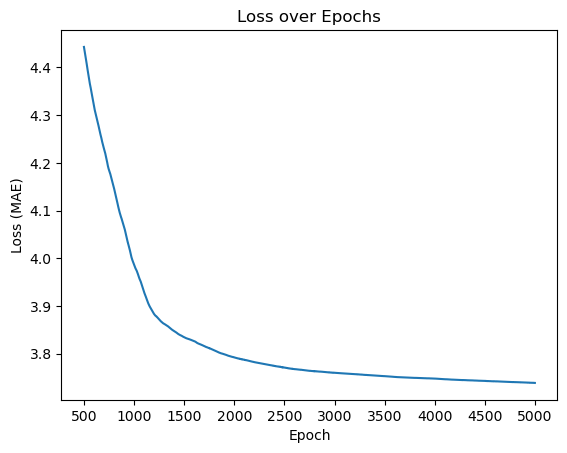

In [ ]:
# plot loss over epochs

# add 500 to x-axis
x_values = range(500, args['training epochs'])
plt.plot(x_values, loss_list[500:])
plt.xticks(range(500, args['training epochs'] + 500, args['training epochs'] // 10))

plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss (MAE)")
plt.show()

# Testing

In [ ]:
# test data
pred_temp = model(spec_test)

In [ ]:
# unscale spectrum data
spec_test = scaler.inverse_transform(spec_test.detach().numpy())

In [ ]:
# plot predicted vs actual graphs for random set of test data
def plot_test_results(pred, actual, index):
    plt.figure(figsize=(15, 5))
    plt.title(f"Temperature Across Layers for Sample {index}")
    plt.xlabel("Layer")
    plt.ylabel("Temperature (K)")
    plt.plot(pred, 'ro', label='predicted')
    plt.plot(actual, 'b', label='actual')
    
    for i in range(len(pred)):
        diff = abs(pred[i] - actual[i])
        plt.text(i, pred[i] + 2, f"{diff:.2f}", fontsize=8, horizontalalignment='center', verticalalignment='center')

    plt.legend()
    plt.show()

test_losses: [5.446449141068892, 9.620032038833155, 6.477518116344105, 5.526552905458392, 6.009165376605409, 6.593079561175722, 6.514166190407493, 4.7633680401426375, 4.826964060465495, 6.130161146684126, 2.3000924081513374]


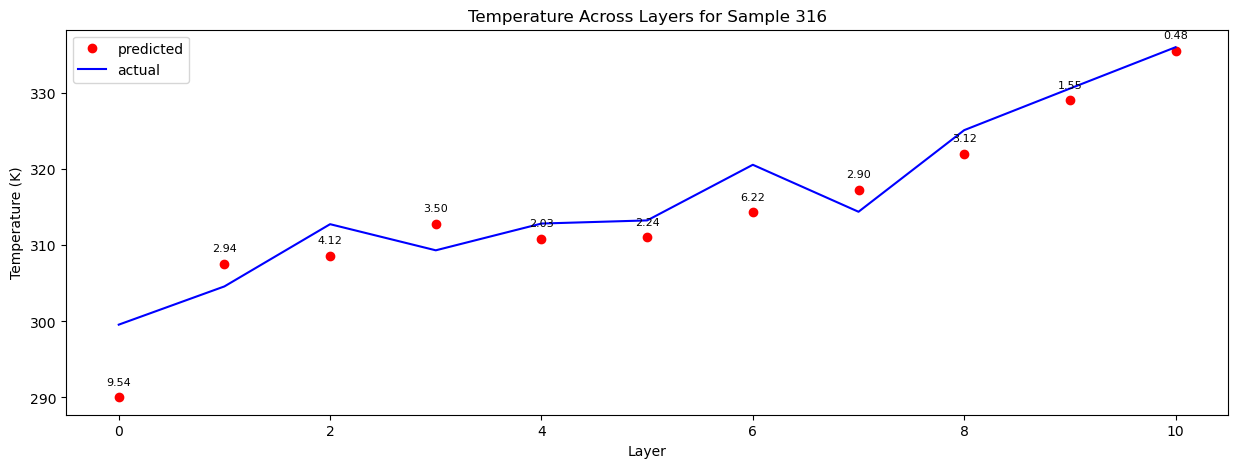

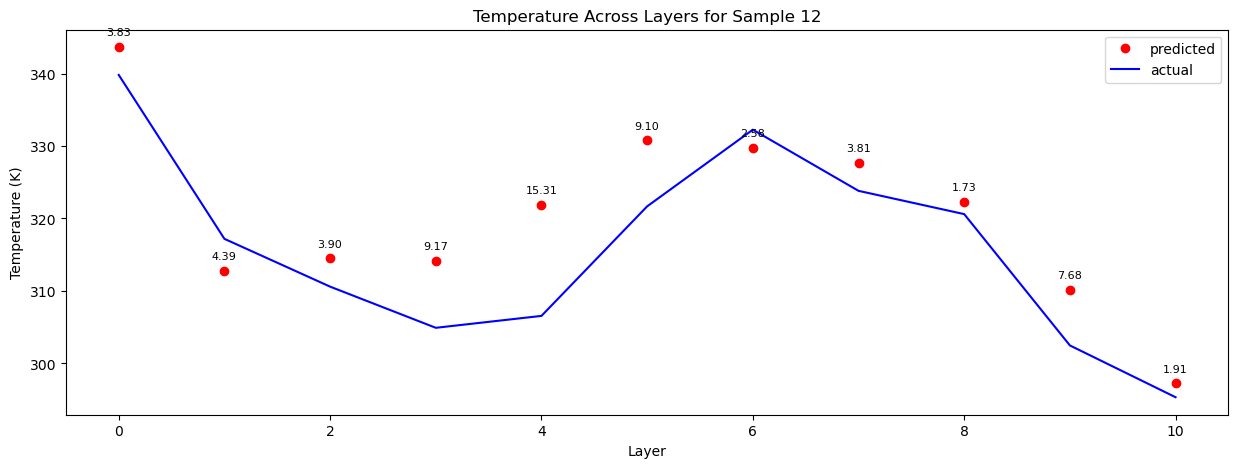

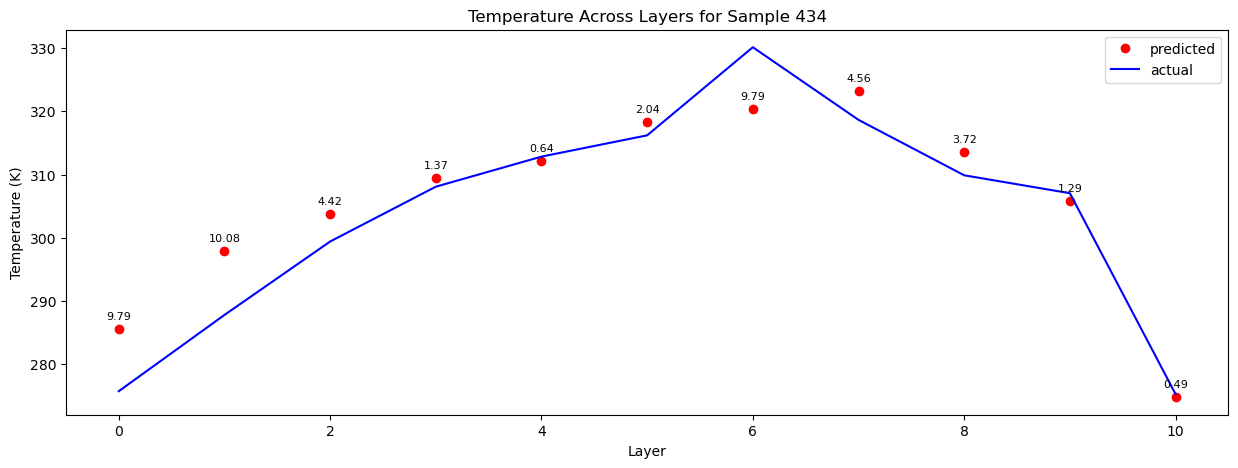

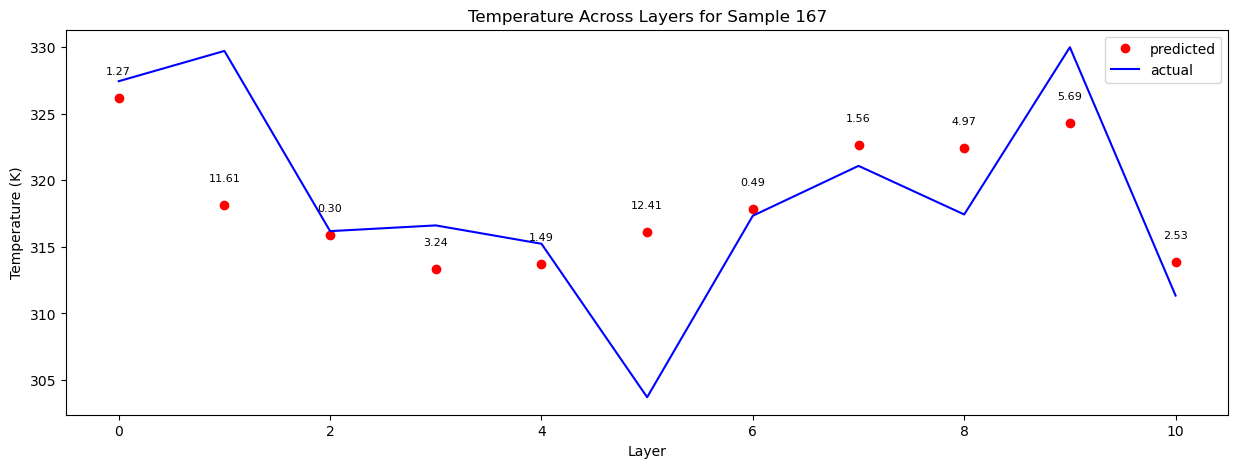

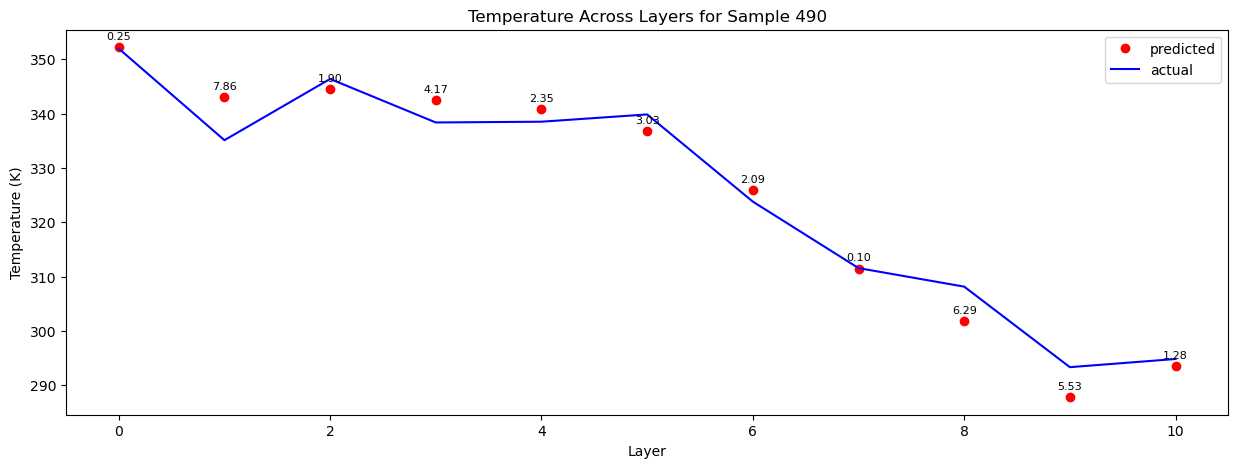

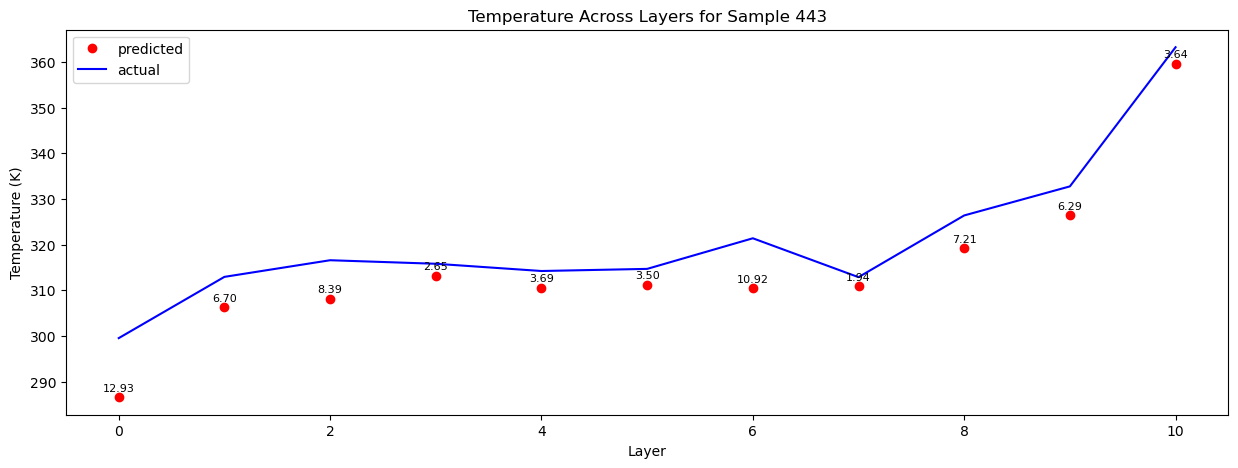

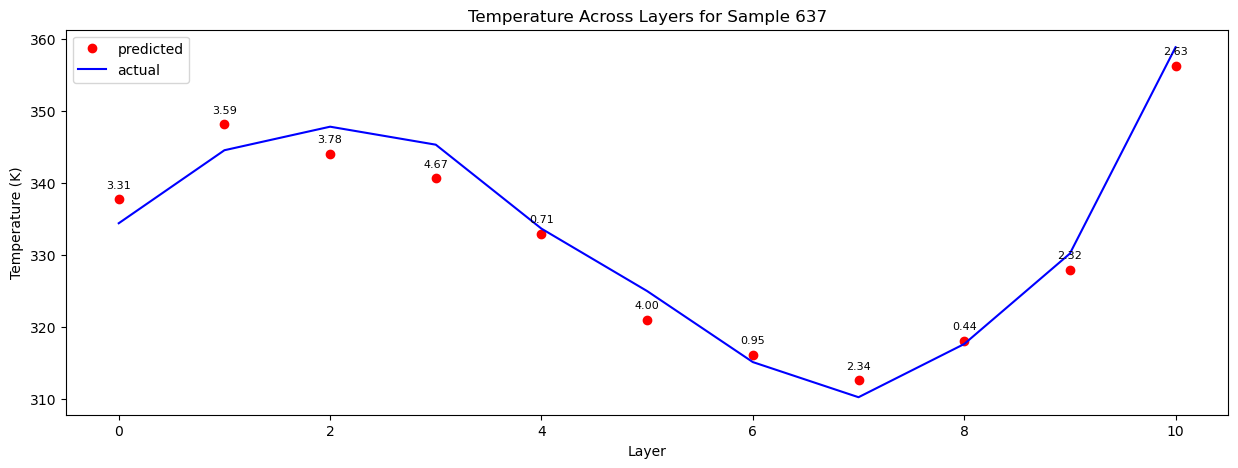

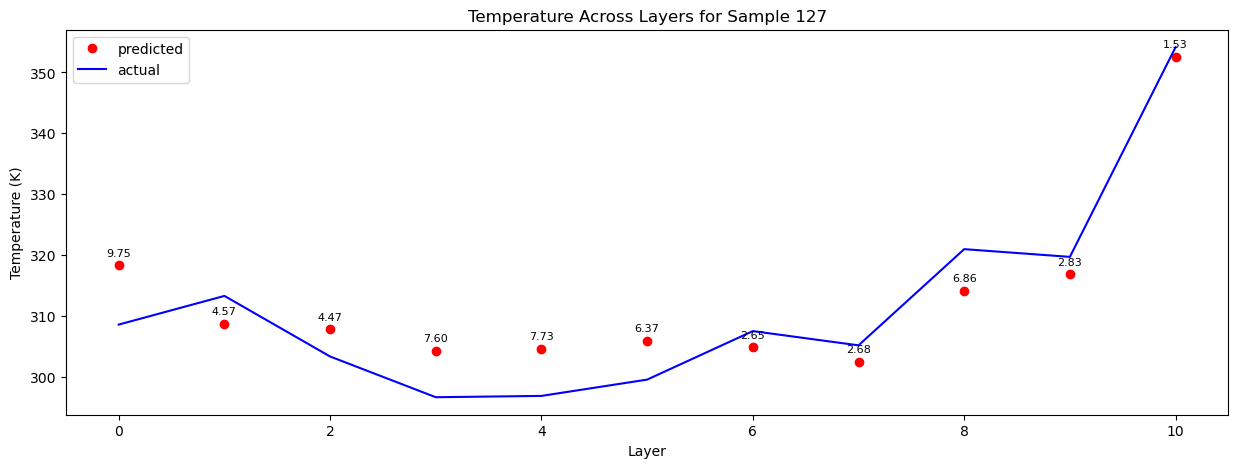

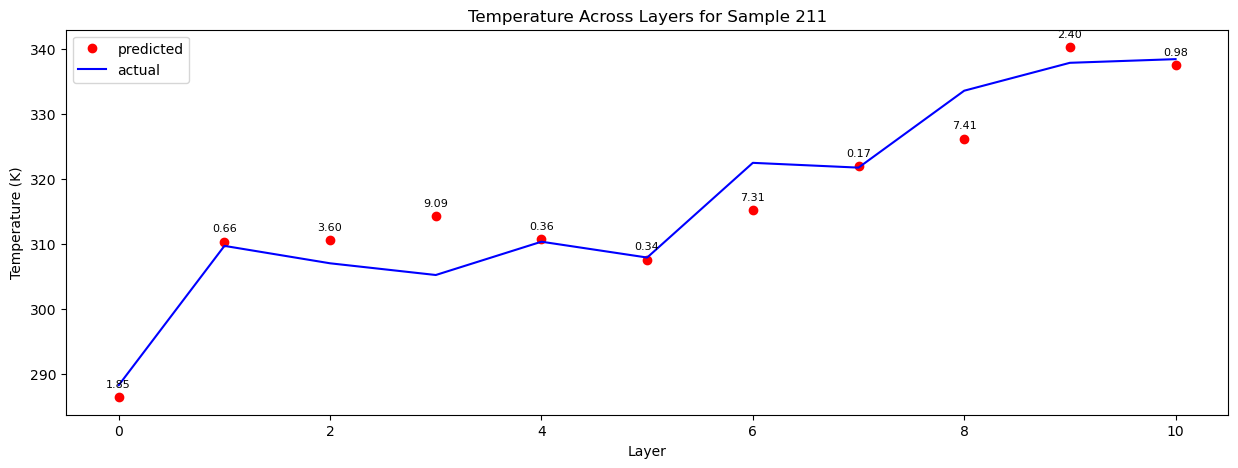

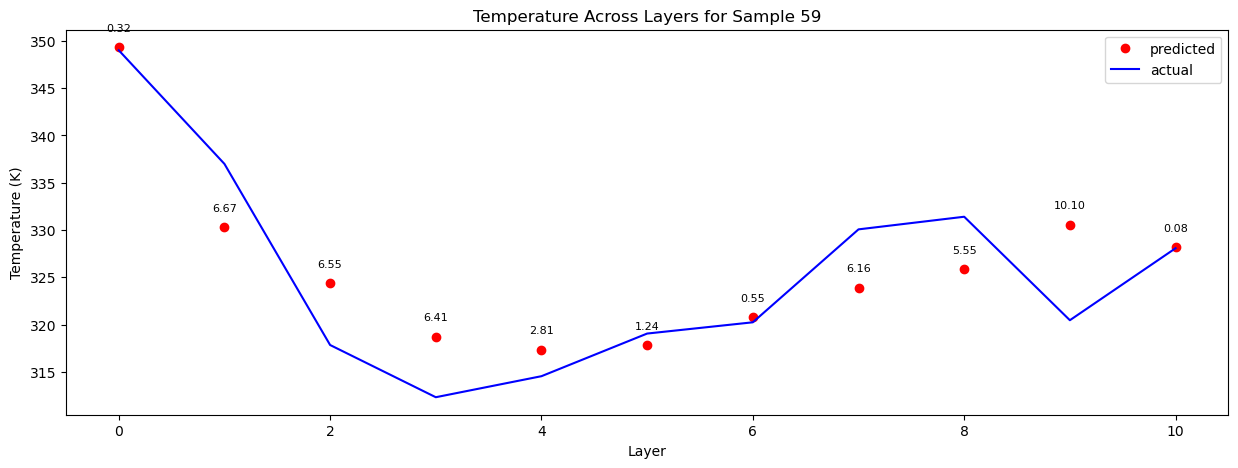

In [ ]:
# find test losses and call plotting function
import random
num_graphs = 10
indices = []

test_losses = [0] * 11


with torch.no_grad():
    for i in range(len(pred_temp)):
        # sum loss for each entry
        for layer in range(len(pred_temp[0])):
            # print(f'layer {layer + 1} pred_temp: {pred_temp[layer]}, layer {layer + 1} temp_test: {temp_test[layer]}')
            l1_loss = abs(pred_temp[i][layer] - temp_test[i][layer]).item()
            test_losses[layer] += l1_loss

    # divide each loss by number of entries to find average loss per layer
    for i in range(len(test_losses)):
        test_losses[i] = test_losses[i] / len(pred_temp)

    print(f'test_losses: {test_losses}')


    # pick random indices to plot
    for i in range(0, num_graphs):
        n = random.randint(0, len(pred_temp))
        indices.append(n)

    # plot data for random set of entries
    for index in indices:
        plot_test_results(pred_temp[index], temp_test[index], index)


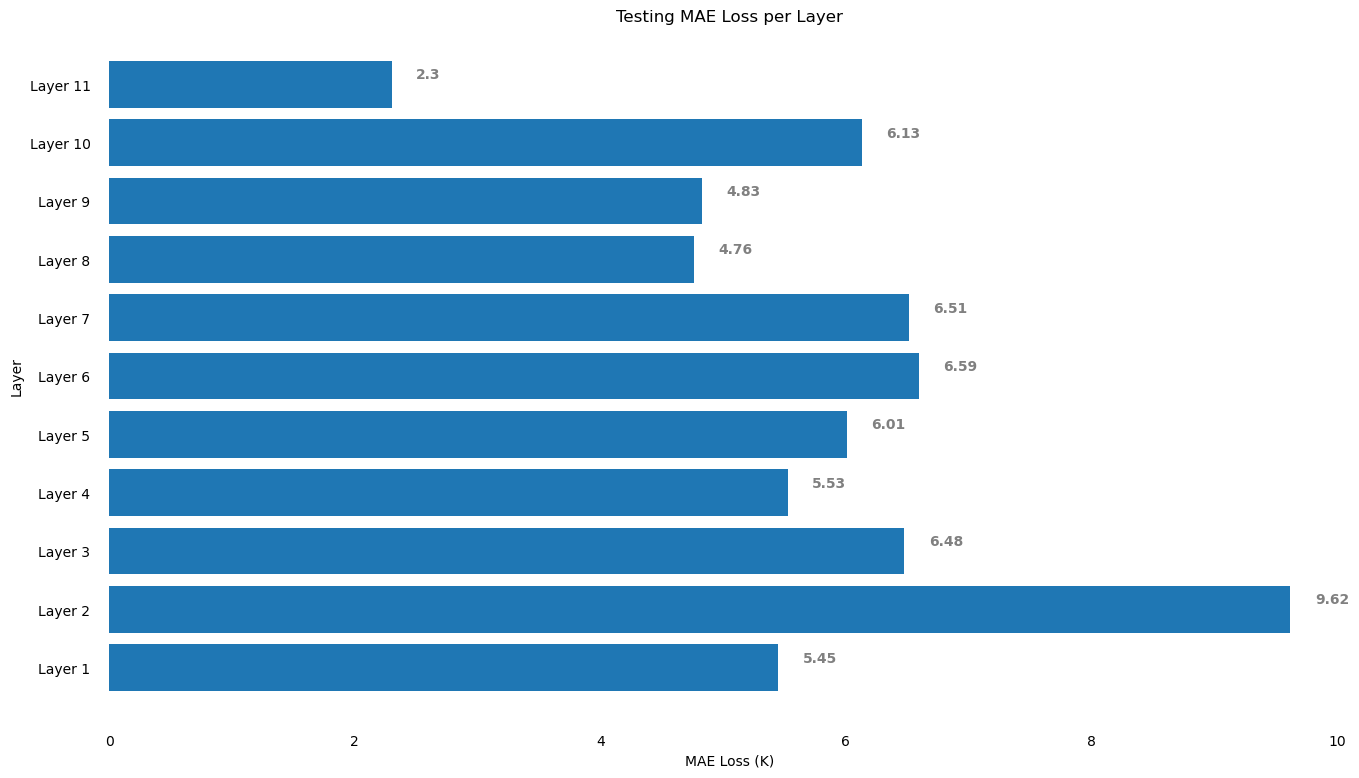

In [ ]:
# Plotting the test losses per layer

# create list of layer names
layer_names = []
for i in range(1, 12):
    layer_names.append(f'Layer {i}')

fig, ax = plt.subplots(figsize =(16, 9))
ax.barh(layer_names, test_losses)
 
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
 
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')

plt.title("Testing MAE Loss per Layer")
plt.xlabel("MAE Loss (K)")
plt.ylabel("Layer")

plt.show()